# Lecture 02: Clustering class demo

![](../img/eva-fun-times.png)

To run the code below, you need to install pytorch and torchvision in the course conda environment. 

```conda install pytorch torchvision -c pytorch```

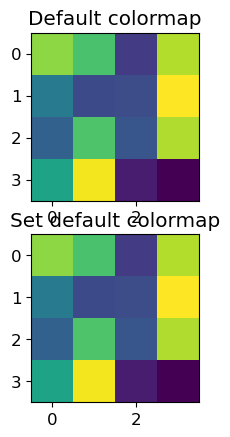

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import torch, torchvision
from torchvision import datasets, models, transforms, utils
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
DATA_DIR = os.path.join(os.path.abspath(".."), "data/")
sys.path.append(os.path.join(os.path.abspath(".."), "code"))
from plotting_functions import *

## Hierarchical clustering on recipes dataset

Let's create a dendrogram on a more realistic dataset. 

We'll use [Kaggle's Food.com recipes corpus](https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions). This corpus contains 180K+ recipes and 700K+ recipe reviews. In this lab, we'll only focus on recipes and **not** on reviews. The recipes are present in `RAW_recipes.csv`. Our goal is to find categories or groupings of recipes from this corpus based on their names. 

In [2]:
orig_recipes_df = pd.read_csv(DATA_DIR + "RAW_recipes.csv")
orig_recipes_df.shape

(231637, 12)

In [3]:
def get_recipes_sample(orig_recipes_df, n_tags=300, min_len=5):
    orig_recipes_df = orig_recipes_df.dropna()  # Remove rows with NaNs.    
    orig_recipes_df = orig_recipes_df.drop_duplicates(
        "name"
    )  # Remove rows with duplicate names.
    orig_recipes_df = orig_recipes_df[orig_recipes_df["name"].apply(len) >= min_len] # Remove rows where recipe names are too short (< 5 characters).
    first_n = orig_recipes_df["tags"].value_counts()[0:n_tags].index.tolist() # Only consider the rows where tags are one of the most frequent n tags.
    recipes_df = orig_recipes_df[orig_recipes_df["tags"].isin(first_n)]
    return recipes_df

In [4]:
recipes_df = get_recipes_sample(orig_recipes_df)
recipes_df.shape

(9100, 12)

In [5]:
recipes_df["name"]

42            i yam what i yam  muffins
101             to your health  muffins
129       250 00 chocolate chip cookies
138                       lplermagronen
163             california roll   salad
                      ...              
231430      zucchini wheat germ cookies
231514         zucchini blueberry bread
231547           zucchini salsa burgers
231596                    zuppa toscana
231629                     zydeco salad
Name: name, Length: 9100, dtype: object

In [6]:
from sentence_transformers import SentenceTransformer
embedder = SentenceTransformer('all-MiniLM-L6-v2')

In [7]:
recipe_names = recipes_df["name"].tolist()
embeddings = embedder.encode(recipe_names)
recipe_names_embeddings = pd.DataFrame(
    embeddings,
    index=recipes_df.index,
)
recipe_names_embeddings

0         1         2         3         4         5         6    \
42      0.019592 -0.088336  0.072677 -0.034575 -0.048741 -0.049801  0.175334   
101    -0.000567 -0.011825  0.073199  0.058175  0.031688 -0.015428  0.168134   
129    -0.022604  0.065034 -0.033065  0.014450 -0.105039 -0.050559  0.100076   
138    -0.066915  0.025988 -0.087689 -0.006847 -0.012861  0.049035  0.035351   
163    -0.007068 -0.007308 -0.026629 -0.004153 -0.052810  0.011126  0.024000   
...          ...       ...       ...       ...       ...       ...       ...   
231430 -0.036366  0.087173 -0.039641  0.002705  0.097142 -0.075385  0.068207   
231514 -0.052718  0.008980 -0.046014  0.030194  0.005201  0.009964 -0.006760   
231547 -0.080801  0.004295 -0.044325  0.038307 -0.030125 -0.063566  0.004788   
231596 -0.060801  0.111672 -0.108755  0.052323 -0.099851 -0.027532  0.084190   
231629 -0.085059  0.009065 -0.088442 -0.008907  0.002234 -0.055801  0.039431   

             7         8         9    ...       374       375       376  \
42     -0.055191  0.020301  0.019828  ...  0.063293 -0.067171  0.087500   
101     0.000466  0.033078 -0.013923  ... -0.012926 -0.015949  0.031315   
129     0.022929 -0.037398  0.011857  ...  0.007971 -0.019165  0.004935   
138     0.124966 -0.011697 -0.050179  ... -0.042345 -0.005794 -0.031800   
163    -0.036994  0.023526 -0.046870  ... -0.018432  0.051918  0.036101   
...          ...       ...       ...  ...       ...       ...       ...   
231430  0.010435 -0.069214  0.010464  ...  0.050988 -0.064541  0.090829   
231514  0.030238 -0.031474  0.024632  ...  0.075467  0.000967  0.085033   
231547  0.004822  0.015525 -0.040094  ...  0.066642  0.016605  0.096211   
231596 -0.004861  0.002891  0.013944  ...  0.038082 -0.014214  0.048392   
231629 -0.037784  0.005315 -0.078361  ...  0.063838  0.035654  0.031519   

             377       378       379       380       381       382       383  
42     -0.061550  0.039297 -0.050147  0.027708  0.056843  0.056151 -0.122506  
101    -0.059074  0.014143 -0.047270  0.007844  0.035501  0.076061 -0.078119  
129     0.009005  0.000919 -0.040078  0.008650 -0.075781 -0.083477 -0.123240  
138     0.120664 -0.057335 -0.077068  0.001653 -0.048223  0.116455  0.021789  
163    -0.035312  0.005817  0.101802 -0.063171 -0.007917  0.089744  0.006997  
...          ...       ...       ...       ...       ...       ...       ...  
231430 -0.004570  0.079109  0.019663 -0.058483 -0.048723  0.019152 -0.012266  
231514 -0.006520  0.031094  0.072901 -0.094975 -0.052466 -0.003300 -0.006991  
231547 -0.023969  0.045752  0.017091 -0.062939 -0.016950  0.012060  0.039776  
231596  0.050377  0.015281  0.106766  0.032009  0.020113  0.004977 -0.005828  
231629 -0.006411  0.007803  0.016261 -0.006218  0.016956  0.019806 -0.042820  

[9100 rows x 384 columns]

<br><br>

In [8]:
def plot_dendrogram(Z, labels, w=15, h=20, p=10):
    fig, ax = plt.subplots(figsize=(w, h))
    dendrogram(
        Z,
        p=p,
        truncate_mode="level",
        orientation="left",
        leaf_font_size=12,
        labels=labels,
        ax=ax,
    )
    ax = plt.gca()
    ax.set_ylabel("Cluster distances", fontsize=w)

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage

recipe_names = recipes_df["name"].tolist()
Z = linkage(embeddings, method="complete", metric="cosine")

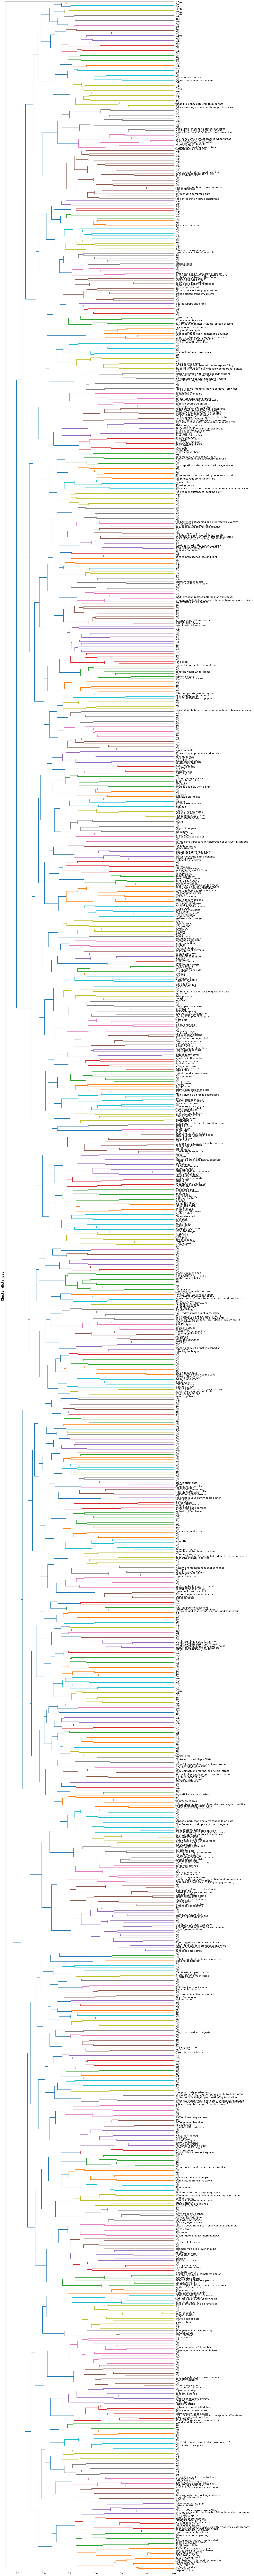

In [10]:
plot_dendrogram(Z, labels=recipe_names, w=15, h=230, p=10)

<br><br><br><br>

## Let's cluster images!!

For this demo, I'm going to use the following image dataset: 
1. A tiny subset of [Food-101](https://www.kaggle.com/datasets/kmader/food41?select=food_c101_n10099_r32x32x1.h5) from last lecture
(available [here](https://github.ubc.ca/mds-2021-22/datasets/blob/master/data/food.zip)).
2. A small subset of [Human Faces dataset](https://www.kaggle.com/datasets/ashwingupta3012/human-faces) (available [here](https://ubcca-my.sharepoint.com/:u:/g/personal/varada_kolhatkar_ubc_ca/EYDqm7QJLfdGh1A0dyqh76kB6PH9ohca-lVrJGATrEh3CQ?e=msqcPM)).

Let's start with  small subset of birds dataset. You can experiment with a bigger dataset if you like.

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
import random
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
set_seed(seed=42)

In [14]:
import glob
IMAGE_SIZE = 224
def read_img_dataset(data_dir, BATCH_SIZE):     
    data_transforms = transforms.Compose(
        [
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),     
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),            
        ])
               
    image_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
    dataloader = torch.utils.data.DataLoader(
         image_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0
    )
    dataset_size = len(image_dataset)
    class_names = image_dataset.classes
    inputs, classes = next(iter(dataloader))
    return inputs, classes

In [15]:
def plot_sample_imgs(inputs):
    plt.figure(figsize=(10, 70)); plt.axis("off"); plt.title("Sample Training Images")
    plt.imshow(np.transpose(utils.make_grid(inputs, padding=1, normalize=True),(1, 2, 0)));

In [16]:
def get_features(model, inputs):
    """Extract output of densenet model"""
    model.eval()
    with torch.no_grad():  # turn off computational graph stuff        
        Z = model(inputs).detach().numpy()         
    return Z

In [17]:
densenet = models.densenet121(weights="DenseNet121_Weights.IMAGENET1K_V1")
densenet.classifier = torch.nn.Identity()  # remove that last "classification" layer

In [18]:
data_dir = "../data/food"
file_names = [image_file for image_file in glob.glob(data_dir + "/*/*.jpg")]
n_images = len(file_names)
BATCH_SIZE = n_images  # because our dataset is quite small
food_inputs, food_classes = read_img_dataset(data_dir, BATCH_SIZE)
n_images

350

In [19]:
X_food = food_inputs.numpy()

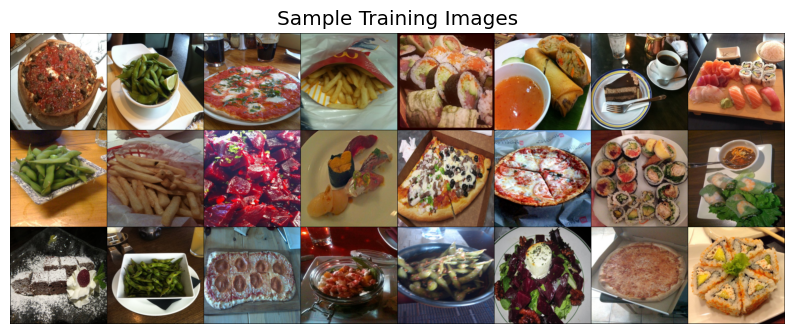

In [20]:
plot_sample_imgs(food_inputs[0:24,:,:,:])

In [21]:
Z_food = get_features(
    densenet, food_inputs, 
)

In [22]:
Z_food.shape

(350, 1024)

In [23]:
from sklearn.cluster import KMeans

k = 7
km = KMeans(n_clusters=k, n_init='auto', random_state=123)
km.fit(Z_food)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


KMeans(n_clusters=7, random_state=123)

82
Image indices:  [ 82 334 265  35 114 343]


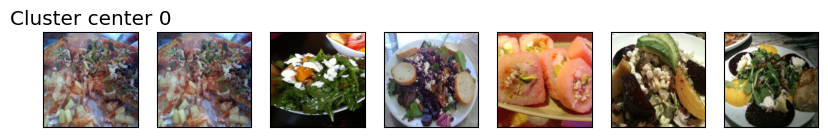

276
Image indices:  [276 191 186  29 265 343]


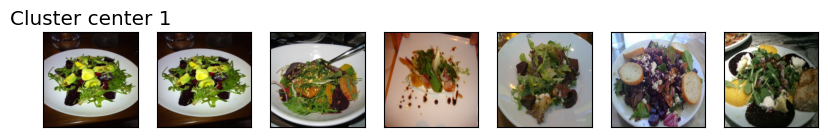

161
Image indices:  [161 102 190 241  56  76]


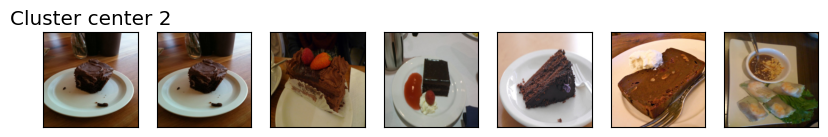

76
Image indices:  [ 76  39 259 295 313 138]


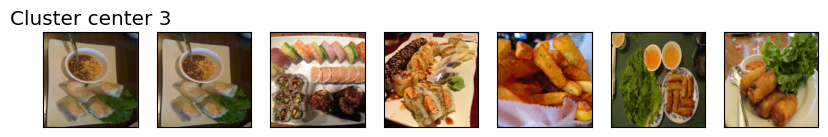

124
Image indices:  [124 253  25  27 223 280]


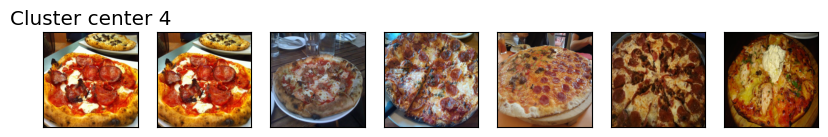

214
Image indices:  [214  20 141 249 203 274]


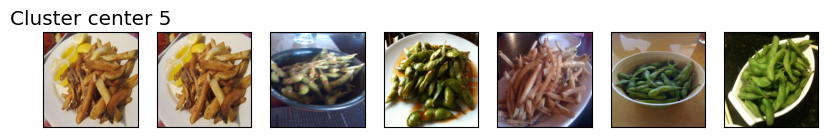

48
Image indices:  [ 48  76  61   5  89 138]


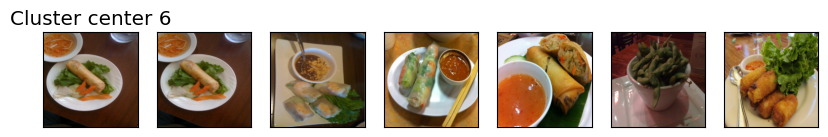

In [24]:
for cluster in range(k):
    get_cluster_images(km, Z_food, X_food, cluster, n_img=6)

Let's try DBSCAN.

In [25]:
dbscan = DBSCAN()

labels = dbscan.fit_predict(Z_food)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1]


It identified all points as noise points. Let's explore the distances between points. 

In [26]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(Z_food)
np.fill_diagonal(dists, np.inf)
dists_df = pd.DataFrame(dists)
dists_df

0          1          2          3          4          5    \
0          inf  27.170071  23.031963  29.344770  27.464485  25.905249   
1    27.170071        inf  22.623034  24.378839  25.491880  21.179726   
2    23.031963  22.623034        inf  28.764124  25.544821  23.159750   
3    29.344770  24.378839  28.764124        inf  28.520519  23.345842   
4    27.464485  25.491880  25.544821  28.520519        inf  21.172096   
..         ...        ...        ...        ...        ...        ...   
345  26.458879  23.107458  25.684532  21.547804  25.304211  22.533875   
346  28.636688  21.258495  26.029633  26.480219  25.343542  21.611742   
347  23.513239  19.471357  20.417009  24.750483  23.945749  19.392572   
348  26.565344  20.257633  21.786682  25.170492  23.584101  19.035461   
349  27.202259  22.101439  22.903080  26.520855  25.460316  21.709145   

           6          7          8          9    ...        340        341  \
0    28.601198  27.226374  27.482910  27.221531  ...  27.895405  28.627741   
1    25.291134  22.400309  17.118835  23.523659  ...  22.605665  19.422024   
2    26.158792  23.423162  23.352556  25.552364  ...  26.763525  25.627256   
3    28.131287  27.448313  24.425112  19.679516  ...  22.209080  26.940434   
4    26.477964  23.458084  24.881807  26.123215  ...  26.482233  24.862644   
..         ...        ...        ...        ...  ...        ...        ...   
345  26.831314  24.927710  22.792894  21.153376  ...  20.873131  24.183716   
346  26.205795  25.979353  20.662205  23.817640  ...  22.648527  21.091988   
347  23.914520  22.881351  20.868397  23.173370  ...  23.511862  23.249804   
348  22.507225  21.890001  18.954798  24.086985  ...  24.703289  22.101406   
349  24.901802  24.091793  23.649513  25.744673  ...  26.223894  25.669897   

           342        343        344        345        346        347  \
0    28.157877  24.296236  27.864172  26.458879  28.636688  23.513239   
1    22.297949  20.873529  24.695156  23.107458  21.258495  19.471357   
2    27.411240  22.771511  24.695322  25.684532  26.029633  20.417009   
3    26.980894  25.166636  27.609039  21.547804  26.480219  24.750483   
4    26.194008  22.634832  26.464815  25.304211  25.343542  23.945749   
..         ...        ...        ...        ...        ...        ...   
345  25.783266  23.444523  25.757412        inf  24.095852  22.627153   
346  21.743132  23.498381  27.345236  24.095852        inf  22.860329   
347  23.443993  17.126707  22.055302  22.627153  22.860329        inf   
348  23.019146  18.728836  22.244556  24.188885  24.492994  18.786024   
349  25.911024  18.624897  25.121590  24.653475  25.513124  18.716599   

           348        349  
0    26.565344  27.202259  
1    20.257633  22.101439  
2    21.786682  22.903080  
3    25.170492  26.520855  
4    23.584101  25.460316  
..         ...        ...  
345  24.188885  24.653475  
346  24.492994  25.513124  
347  18.786024  18.716599  
348        inf  22.293304  
349  22.293304        inf  

[350 rows x 350 columns]

In [27]:
dists.min(), np.nanmax(dists[dists != np.inf]), np.mean(dists[dists != np.inf])

(np.float32(10.06717), np.float32(36.652683), np.float32(24.538565))

In [28]:
for eps in range(13, 20):
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(Z_food)
    print("Number of clusters: {}".format(len(np.unique(labels))))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=13
Number of clusters: 2
Cluster sizes: [347   3]

eps=14
Number of clusters: 5
Cluster sizes: [334   3   6   4   3]

eps=15
Number of clusters: 4
Cluster sizes: [299  26   8  17]

eps=16
Number of clusters: 4
Cluster sizes: [248  86   3  13]

eps=17
Number of clusters: 2
Cluster sizes: [205 145]

eps=18
Number of clusters: 2
Cluster sizes: [160 190]

eps=19
Number of clusters: 2
Cluster sizes: [116 234]


In [29]:
dbscan = DBSCAN(eps=14, min_samples=3)
dbscan_labels = dbscan.fit_predict(Z_food)
print("Number of clusters: {}".format(len(np.unique(dbscan_labels))))
print("Cluster sizes: {}".format(np.bincount(dbscan_labels + 1)))
print("Unique labels: {}".format(np.unique(dbscan_labels)))

Number of clusters: 5
Cluster sizes: [334   3   6   4   3]
Unique labels: [-1  0  1  2  3]


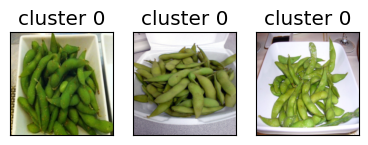

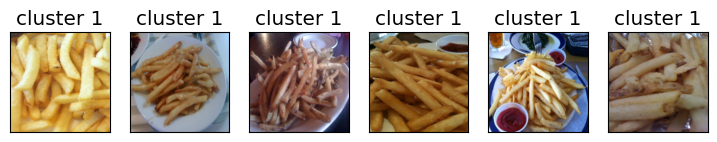

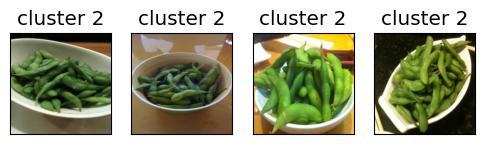

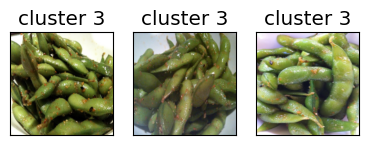

In [30]:
print_dbscan_clusters(Z_food, food_inputs, dbscan_labels)

Let's examine noise points identified by DBSCAN. 

In [ ]:
print_dbscan_noise_images(Z_food, food_inputs, dbscan_labels)

<br><br>